<a href="https://colab.research.google.com/github/okimb/Systeme-de-recommandation/blob/master/recommender_systeme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
%matplotlib inline
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
DATA_SET_NAME = 'ml-20m'
DATA_PATH = '/gdrive/My Drive/'

**1. Nous avons téléchargé le data set Movilens 20M et nous l'avons chargé dans notre Drive**


In [0]:
from urllib.request import urlretrieve
from tqdm import tqdm
import zipfile

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

        
def download_extract():
    """
    Download and extract database
    """
    url = 'http://files.grouplens.org/datasets/movielens/' + DATA_SET_NAME + '.zip'
    
    if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)
    
    file_path = os.path.join(DATA_PATH, DATA_SET_NAME + '.zip')
    
    # download data:
    if not os.path.exists(file_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading ml-20m.zip') as pbar:
            urlretrieve(
                url,
                file_path,
                pbar.hook)
    else:
        return
    
    print('Extracting data...')
    with zipfile.ZipFile(file_path) as zf:
        zf.extractall(DATA_PATH)

    print('Done.')

**2. Chargement et prévisualisation des données**

In [0]:
print('movies.csv: ')
movies = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'movies.csv'),index_col=None)
movies.describe()
movies.head(5)

movies.csv: 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
print('ratings.csv: ')
ratings = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'ratings.csv'),index_col=None)
ratings.describe()
ratings.head(5)

ratings.csv: 


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
print('tags.csv: ')
tags = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'tags.csv'),index_col=None)
tags.describe()
tags.head(5)

tags.csv: 


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [0]:
print('genome-tags.csv: ')
genome_tags = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'genome-tags.csv'),index_col=None)
genome_tags.describe()
genome_tags.head(5)

genome-tags.csv: 


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [0]:
print('genome-scores.csv: ')
genome_scores = pd.read_csv(os.path.join(DATA_PATH, DATA_SET_NAME,'genome-scores.csv'),index_col=None)
genome_scores.describe()
genome_scores.head(5)

genome-scores.csv: 


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


**3. Simples tatistiques sur les données**

 Cette statistique nous aidera à mieux comprendre nes données.



In [0]:
print('The number of movies: {}'.format(movies.count()['movieId']))
print('The number of ratings: {}'.format(ratings.count()['movieId']))

print('')
print('min value of rating: {}'.format(ratings['rating'].min()))
print('max value of rating: {}'.format(ratings['rating'].max()))

print('')
ra = ratings.groupby(ratings['userId']).count()
print('The number of user in ratings.csv: {}'.format(ra.count()[0]))
print('The minimum number of ratings per user in ratings.csv: {}'.format(ra['movieId'].min()))
print('The maximun number of ratings per user in ratings.csv: {}'.format(ra['movieId'].max()))

print('')
ra = ratings.groupby(ratings['movieId']).count()
print('The number of movies in ratings.csv: {}'.format(ra.count()[0]))
print('The minimum number of ratings per movie in ratings.csv: {}'.format(ra['userId'].min()))
print('The maximun number of ratings per movie in ratings.csv: {}'.format(ra['userId'].max()))

The number of movies: 27278
The number of ratings: 20000263

min value of rating: 0.5
max value of rating: 5.0

The number of user in ratings.csv: 138493
The minimum number of ratings per user in ratings.csv: 20
The maximun number of ratings per user in ratings.csv: 9254

The number of movies in ratings.csv: 26744
The minimum number of ratings per movie in ratings.csv: 1
The maximun number of ratings per movie in ratings.csv: 67310


In [0]:
print('The number of tags in tags.csv: {}'.format(tags.count()['userId']))
print('The number of tags in genome-tags.csv: {}'.format(genome_tags.count()['tagId']))

print('')
ra = tags.groupby(tags['userId']).count()
print('The number of user in tags.csv: {}'.format(ra.count()[0]))
print('The minimum number of tags per user in tags.csv: {}'.format(ra['movieId'].min()))
print('The maximun number of tags per user in tags.csv: {}'.format(ra['movieId'].max()))

print('')
ra = tags.groupby(tags['movieId']).count()
print('The number of movies in tags.csv: {}'.format(ra.count()[0]))
print('The minimum number of tags per movie in tags.csv: {}'.format(ra['userId'].min()))
print('The maximun number of tags per movie in tags.csv: {}'.format(ra['userId'].max()))

print('')
tags_mer = pd.merge(tags, genome_tags, how='left', left_on='tag', right_on='tag')
print('The number of tags in tags.csv but not in genome-tags.csv: {}'.format(tags_mer[(tags_mer['tagId'].isnull())].count()[0]))

The number of tags in tags.csv: 465564
The number of tags in genome-tags.csv: 1128

The number of user in tags.csv: 7801
The minimum number of tags per user in tags.csv: 1
The maximun number of tags per user in tags.csv: 20356

The number of movies in tags.csv: 19545
The minimum number of tags per movie in tags.csv: 1
The maximun number of tags per movie in tags.csv: 1994

The number of tags in tags.csv but not in genome-tags.csv: 247993


In [0]:
print('The length of genome_scores.csv: {}'.format(genome_scores.count()['movieId']))
print('max value of relevance from genome_scores.csv: {}'.format(genome_scores['relevance'].max()))
print('min value of relevance from genome_scores.csv: {}'.format(genome_scores['relevance'].min()))

print('')
ra = genome_scores.groupby(genome_scores['movieId']).count()
print('The number of movies in genome_scores.csv: {}'.format(ra.count()[0]))
print('The minimum number of tags per movie in genome_scores.csv: {}'.format(ra['tagId'].min()))
print('The maximun number of tags per movie in genome_scores.csv: {}'.format(ra['tagId'].max()))

The length of genome_scores.csv: 11709768
max value of relevance from genome_scores.csv: 1.0
min value of relevance from genome_scores.csv: 0.00024999999999997247

The number of movies in genome_scores.csv: 10381
The minimum number of tags per movie in genome_scores.csv: 1128
The maximun number of tags per movie in genome_scores.csv: 1128


In [0]:
# Analysis the relevant data of movies in both genome_scores.csv and ratings.csv:

genome_scores_group = genome_scores.groupby(genome_scores['movieId']).mean()
ratings_group = ratings.groupby(ratings['movieId']).mean()
rat_ge_merge = pd.merge(ratings_group, genome_scores_group, how='inner', left_on='movieId', right_on='movieId')
number = rat_ge_merge.count()[0]
print('Number of movies in both genome_scores.csv and ratings.csv: {}. Take up {}% of ratings.csv'\
      .format(number, round(number/19545*100)))

ratings_genome_merge = pd.merge(ratings, genome_scores_group, how='inner', left_on='movieId', right_on='movieId')
number = ratings_genome_merge.count()[0]
print('Number of ratings where its movieId in genome_scores.csv: {}. Take up {}% of ratings.csv'\
      .format(number, round(number/20000263*100)))

print('')
ra = ratings_genome_merge.groupby(ratings_genome_merge['userId']).count()
number = ra.count()[0]
print('{} users rate the movies appearing in both genome_scores.csv and ratings.csv. Take up {}% of ratings.csv'\
      .format(number, round(number/138493*100)))
print('Minimum number of ratings per user for the movies appearing in both genome_scores.csv and ratings.csv: {}'.format(ra['movieId'].min()))

Number of movies in both genome_scores.csv and ratings.csv: 10370. Take up 53.0% of ratings.csv
Number of ratings where its movieId in genome_scores.csv: 19800443. Take up 99.0% of ratings.csv

138493 users rate the movies appearing in both genome_scores.csv and ratings.csv. Take up 100.0% of ratings.csv
Minimum number of ratings per user for the movies appearing in both genome_scores.csv and ratings.csv: 13


**4. Hypotheses et model de l'apprentissage automatique**

**4.1 Hypothèse**


1.   Les balises de genome-tags.csv constituent l'ensemble complet des espaces vectoriels de balises. Les autres balises ne figurant pas dans génome-tags.csv sont des combinaisons linéaires de balises dans le génome-tags.csv.
2.   La fonctionnalité des films peut être parfaitement représentée par des balises dans genome-tags.csv, telles que le vecteur de pertinence dans genome_scores.csv. Le vecteur de pertinence dans genome_scores.csv est correct et peut représenter la fonctionnalité de films;
3.   Ignorer la qualité des films;
4.   Nous ne pouvons pas obtenir d'autres informations sur les films en dehors de l'ensemble de données. Donc, nous n'utilisons pas links.csv;
5.   La durée de sortie des films n’affecte pas
6.    L'horodatage dans ratings.csv: et tags.csv n'affecte pas.


**Definition du Problème**

Nous avons choisi un data set de 19800443 d'évaluation pour construire un modèle afin de pouvoir vérifier notre hypothèse. 

*   Ces 19800443 évaluations sont classifiées selons 10370 films différents et 138493 utilisateurs différents;
*   Chaque film a un vecteur de pertinence unique;
*   L'objectif prémier de notre travail c'est de predir les filmes à un utilisateur à travers son identifiant et l'identifiant d'un filme de son choix.





**Creation de données d'entrainement**

Nous avons subdivisé 19800443 données évaluées et classifées (du fichier genome_scores.csv selon movieId) en (80%) de données d'entrainement et en (20%) de données de test. Nous pouvons constater que les données test contient 99,86% des utilisateurs. le chargement des données pretraités se feront dans la cellule de code de la section suivant.

In [0]:
# Preprocess data (You should run last code cell to get 'ratings_genome_merge')
# The first column of features is userId, the next is movieId.
# The only one column of target is rating.

remove_fields = ['timestamp','tagId','relevance','rating']
target = ratings_genome_merge['rating']
feature = ratings_genome_merge.drop(remove_fields, axis=1)
features = feature.values
target = target.values

genome_scores_dict = {}
for i in range(10381):
    m_id = -1
    vec = []
    for j in range(1128):
        index = j + i * 1128
        if m_id < 0:
            m_id = genome_scores['movieId'][index]
        assert genome_scores['movieId'][index] == m_id
        assert genome_scores['tagId'][index] == j + 1
        vec.append(genome_scores['relevance'][index])
    genome_scores_dict[str(m_id)] = vec

In [0]:
# Actually, using train_test_split in here is not best. 
# The better method should split the data according the userId, which make sure every user is in the test set.
# But here, let us make it easier and quickly ( We have already include 99.86% users).
from sklearn.model_selection import train_test_split
train_features,test_features, train_target, test_target = train_test_split(features,  
                                                           target,  
                                                           test_size = 0.2,  
                                                           random_state = 0)

dict_t = {}
dict_t['userId'] = test_features[:,0]
dict_t['movieId'] = test_features[:,1]
pd_data = pd.DataFrame.from_dict(dict_t)
user_test = pd_data.groupby(pd_data['userId']).count().count()[0]

print('{}% users in test set ({} users)'.format(round(user_test/138493*100, 2), user_test ))

dict_t = {}
dict_t['userId'] = train_features[:,0]
dict_t['movieId'] = train_features[:,1]
pd_data = pd.DataFrame.from_dict(dict_t)
user_train = pd_data.groupby(pd_data['userId']).count().count()[0]

print('{}% users in training set ({} users)'.format(round(user_train/138493*100, 2), user_train ))

99.86% users in test set (138294 users)
100.0% users in training set (138493 users)


In [0]:
# Save preprocess data to '/gdrive/My Drive/verify_assumption.data'
pickle.dump((train_features, test_features, train_target, test_target, genome_scores_dict), open('/gdrive/My Drive/verify_assumption.data', 'wb'))

In [0]:
# Load preprocess data from '/gdrive/My Drive/verify_assumption.data'
train_features, test_features, train_target, test_target, genome_scores_dict = pickle.load(open('/gdrive/My Drive/verify_assumption.data', mode='rb'))

**4.4  construction du modèle**

Si le vecteur de pertinence correspondant  au genome_scores.csv peut représenter les films, nous pouvons l’utiliser pour créer un modèle prédictif selons les note attribuée par les utilisateurs. Pour ceux, nous donnons un modèle simplde de l'apprentissage automatique. 

**les paramettres du model**

In [0]:
batch_size = 768  # batch size "taille du lot"
lr = 1e-3         # learning rate "taux d'apprentissage"
feature_dim = 512 # Dimension of movie or user feature vector 'Dimension du film ou du vecteur de fonctionnalités utilisateur'
Epoch = 6         # train epoch "époque du train"

**Model¶**

In [0]:
class Verify_Assumption_Model(nn.Module):
    """The whole model"""
    def __init__(self):
        super(Verify_Assumption_Model, self).__init__()
        self.emb_user = nn.Embedding(138493 + 1, 512, # use ratings['userId'].max()+1 instead of 138493+1 is better
                            padding_idx=0)
        
        self.movie_transfrom = nn.Sequential(
            nn.Linear(1128, 512),
            nn.Tanh(), # activation function can not be the final layer of Sequential. But it can be the first one.
            nn.Linear(512, 512)
        )
    
    def forward(self, userId, movieVector):
        v_user  = self.emb_user(userId)
        v_movie = self.movie_transfrom(movieVector)
        v_user.unsqueeze_(1)
        v_movie.unsqueeze_(2)
        return torch.bmm(v_user,v_movie)

In [0]:
len_train_features = len(train_features)
index = 0
model = Verify_Assumption_Model()
model.cuda()

loss_fn = torch.nn.MSELoss(reduce=False, size_average=False)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                               lr=lr, weight_decay=0)
losses = {'train':[], 'test':[]}

for epoch_i in range(Epoch):
    index = 0
    while index <= len_train_features:
        index_end = index + batch_size
        if index_end >= len_train_features:
            batch_train = train_features[index:len_train_features]
            batch_train_target = train_target[index:len_train_features]
        else:
            batch_train = train_features[index:index_end]
            batch_train_target = train_target[index:index_end]

        #assert len(batch_train) == len(batch_train_target)

        userId = batch_train[:,0]
        movieId = batch_train[:,1]
        movie_vec = []
        for i in range(len(movieId)):
            movie_vec.append(genome_scores_dict[str(movieId[i])])


        rating = model(torch.tensor(userId, requires_grad = False).cuda(),torch.tensor(movie_vec, requires_grad = False).cuda())
        rating = rating.squeeze_(1).squeeze_(1)
        loss = sum(loss_fn(rating,torch.tensor(batch_train_target,dtype=torch.float32,requires_grad = False).cuda()))

        opt.zero_grad()
        loss.backward()
        losses['train'].append(loss.detach().cpu().numpy())
        opt.step()
        if len(losses['train']) % 500 == 0:
            print('Epoch {:>3} Batch {:>4}/15840354   train_loss = {:.3f}'.format(
                        epoch_i,
                        index,
                        losses['train'][len(losses['train'])-1]))
        index += batch_size
        
    #############################test#############################
    
    len_test_features = len(test_features)
    index = 0

    while index <= len_test_features:
        index_end = index + batch_size
        if index_end >= len_train_features:
            batch_train = test_features[index:len_train_features]
            batch_train_target = test_target[index:len_train_features]
        else:
            batch_train = test_features[index:index_end]
            batch_train_target = test_target[index:index_end]

        #assert len(batch_train) == len(batch_train_target)

        userId = batch_train[:,0]
        movieId = batch_train[:,1]
        movie_vec = []
        for i in range(len(movieId)):
            movie_vec.append(genome_scores_dict[str(movieId[i])])


        rating = model(torch.tensor(userId, requires_grad = False).cuda(),torch.tensor(movie_vec, requires_grad = False).cuda())
        rating = rating.squeeze_(1).squeeze_(1)
        loss = sum(loss_fn(rating,torch.tensor(batch_train_target,dtype=torch.float32,requires_grad = False).cuda()))

        losses['test'].append(loss.detach().cpu().numpy())
        if len(losses['test']) % 500 == 0:
            print('Epoch {:>3} Batch {:>4}/3960089   test_loss = {:.3f}'.format(
                        epoch_i,
                        index,
                        losses['test'][len(losses['test'])-1]))
        index += batch_size

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch   0 Batch 383232/15840354   train_loss = 11533.780
Epoch   0 Batch 767232/15840354   train_loss = 8228.780
Epoch   0 Batch 1151232/15840354   train_loss = 4863.979
Epoch   0 Batch 1535232/15840354   train_loss = 2620.337
Epoch   0 Batch 1919232/15840354   train_loss = 2049.221
Epoch   0 Batch 2303232/15840354   train_loss = 1910.178
Epoch   0 Batch 2687232/15840354   train_loss = 1392.610
Epoch   0 Batch 3071232/15840354   train_loss = 1405.845
Epoch   0 Batch 3455232/15840354   train_loss = 1242.801
Epoch   0 Batch 3839232/15840354   train_loss = 1350.883
Epoch   0 Batch 4223232/15840354   train_loss = 1300.026
Epoch   0 Batch 4607232/15840354   train_loss = 1369.943
Epoch   0 Batch 4991232/15840354   train_loss = 1185.802
Epoch   0 Batch 5375232/15840354   train_loss = 1209.570
Epoch   0 Batch 5759232/15840354   train_loss = 1210.279
Epoch   0 Batch 6143232/15840354   train_loss = 1245.999
Epoch   0 Batch 6527232/15840354   train_loss = 1135.006
Epoch   0 Batch 6911232/15840354

In [0]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

NameError: ignored

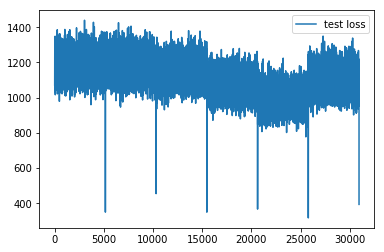

In [0]:
plt.plot(losses['test'], label='test loss')
plt.legend()
_ = plt.ylim()

In [0]:
# Save model to '/gdrive/My Drive/model.pt'
model = Verify_Assumption_Model()
torch.save(model.state_dict(), '/gdrive/My Drive/model.pt')

In [0]:
# Load model from state_dict file '/gdrive/My Drive/model.pt'
model = Verify_Assumption_Model()
model.load_state_dict(torch.load('/gdrive/My Drive/model.pt', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
model_save_name = 'model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load('/gdrive/My Drive/model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
device = torch.device('cpu')
model = Verify_Assumption_Model()
model.load_state_dict(torch.load('/gdrive/My Drive/model.pt', map_location=device))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
model = Verify_Assumption_Model()
model.load_state_dict(torch.load('/gdrive/My Drive/model.pt'), strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

**4.5 Analyse des résultats et évaluation**

Nous pouvons voir que la perte de test diminue lentement puis augmente lentement. Cela suppose que nous obtiendrons un meilleur résultat en modifiant les paramètres. Cependant, étant donné que le temps d’entraînement est trop long, il n’y a pas assez de temps pour modifier différents paramètres pour l’expérimentation. Nous le ferons plus tard.
La performance de ce modèle est donc bonne, et cela peut nous aider à vérifier l’hypothèse: le vecteur de pertinence peut représenter des films.

**5 système de recommandation**

Sur la base du modèle présenté au chapitre 4, nous pouvons créer un système de recommandation capable de:


1.   Donner une liste de films liés à un film;
2.   prédire les films préférés des utilisateurs;
3.   Recommander des films pertinents que l'utilisateur souhaite et que l'utilisateur vient de regarder.





**5.1 Recommander des films pertinents**

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
def get_relevant_movies(id, orginal=True, movie_num=10):
    
    movie_feature = []
    movie_id = []
    movie_num += 1 # because the most relevant movie is the same movie.
    
    # Get all movie vector, You can run quickly if you save the movie vector in your memory.
    for key in genome_scores_dict.keys():
        movie_id.append(key)
        if orginal:     
            norm = np.linalg.norm(genome_scores_dict[key],ord=2) 
            movie_feature.append(genome_scores_dict[key]/norm)
        else:
            v = model.movie_transfrom(torch.tensor(genome_scores_dict[key]).cuda()).cpu().detach().numpy()
            norm = np.linalg.norm(v,ord=2) 
            movie_feature.append(v/norm)

    movie_feature = torch.tensor(movie_feature).unsqueeze_(1).cuda()

    if orginal: 
        norm = np.linalg.norm(genome_scores_dict[str(id)],ord=2)
        in_movie = torch.tensor(genome_scores_dict[str(id)]/norm).expand(10381, 1128).unsqueeze_(2).cuda()
    else:
       # v = model.movie_transfrom(torch.tensor(genome_scores_dict[str(id)]).cuda()).cpu().detach().numpy()
        v = model.movie_transfrom(torch.tensor(genome_scores_dict[str(id)]).cuda()).cpu().detach().numpy()
        norm = np.linalg.norm(v,ord=2)
        in_movie = torch.tensor(v/norm).cuda().expand(10381, 512).unsqueeze_(2)
    
    similarity = torch.bmm(movie_feature,in_movie).squeeze_(1).squeeze_(1).cpu().detach().numpy()
    index = np.argpartition(similarity, -movie_num)[-movie_num:]
    
    if orginal: 
        print('Find relevant movies based on relevance vector from genome-scores.csv')
    else:
        print('Find relevant movies based on movie feature vector from training model')
    
    print('')
    print('Input Movie: {}'.format(movies[movies['movieId']==id].values[0]))
    print('')
    print('Relevant Movie:')
    
    re = []
    for i in index:
        if movie_id[i] != str(id):
            print('    {}'.format(movies[movies['movieId']==int(movie_id[i])].values[0]))
            re.append(movie_id[i])
            
    return re

**Analyser le résultat sur la prochaine cellule **

Nous présentons ici la recherche de film pertinente basée sur le modèle d’apprentissage automatique et le vecteur de pertinence de genome_scores.csv. Nous constatons que les deux méthodes peuvent trouver des films pertinents, et il existe un certain chevauchement entre les deux méthodes. Je pense que le vecteur de caractéristiques de film du modèle est proche du vecteur de pertinence de genome_scores.csv.

In [0]:
get_relevant_movies(2,True)
print('')
print('--------------------------------')
print('')
get_relevant_movies(2,False)
pass

Find relevant movies based on relevance vector from genome-scores.csv

Input Movie: [2 'Jumanji (1995)' 'Adventure|Children|Fantasy']

Relevant Movie:
    [2047 'Gnome-Mobile, The (1967)' 'Adventure|Children|Fantasy|Musical']
    [1920 'Small Soldiers (1998)' 'Animation|Children|Fantasy|War']
    [480 'Jurassic Park (1993)' 'Action|Adventure|Sci-Fi|Thriller']
    [7781 'Twister (1990)' 'Comedy']
    [455 'Free Willy (1993)' 'Adventure|Children|Drama']
    [40851 'Zathura (2005)' 'Action|Adventure|Children|Fantasy']
    [2429 'Mighty Joe Young (1998)' 'Action|Adventure|Drama|Fantasy|Thriller']
    [46972 'Night at the Museum (2006)' 'Action|Comedy|Fantasy|IMAX']
    [2054 'Honey, I Shrunk the Kids (1989)'
 'Adventure|Children|Comedy|Fantasy|Sci-Fi']
    [1848 'Borrowers, The (1997)' 'Adventure|Children|Comedy|Fantasy']

--------------------------------

Find relevant movies based on movie feature vector from training model

Input Movie: [2 'Jumanji (1995)' 'Adventure|Children|Fantasy']


**Prédire à un utilisateur ses films préférés**


In [0]:
def guess_your_favourite(userId, movie_num=10):
    
    user_vector = model.emb_user(torch.tensor([userId]).cuda()).expand(10381, 512).unsqueeze_(2).cuda()
    
    movie_feature = []
    movie_id = []
    for key in genome_scores_dict.keys():
        movie_id.append(key)
        movie_feature.append(model.movie_transfrom(torch.tensor(genome_scores_dict[key]).cuda()).cpu().detach().numpy())

    movie_feature = torch.tensor(movie_feature).unsqueeze_(1).cuda()

    favourite_v = torch.bmm(movie_feature,user_vector).squeeze_(1).squeeze_(1).cpu().detach().numpy()
    index = np.argpartition(favourite_v, -movie_num)[-movie_num:]
    
    
    print('Find your top{} favourite movies'.format(movie_num))
    
    print('')
    print('Favourite Movie:')
    
    re = []
    for i in index:
        if movie_id[i] != str(id):
            print('    {}'.format(movies[movies['movieId']==int(movie_id[i])].values[0]))
            re.append(movie_id[i])
            
    print('')
    print('The rating of these movies by user {}'.format(userId))
    
    for i in re:
        result = ratings[(ratings['movieId']==int(i))&(ratings['userId']==userId)].values
        if len(result) > 0:
            print('    Movie ({:>5}). Rating: {}'.format(i, result[0][2]))
        else:
            print('    There is no rating on this movie ({:>6}) by user.'.format(i))
    return re

**Analysis the result on next code cell**

In [0]:
guess_your_favourite(7)
pass

Find your top10 favourite movies

Favourite Movie:
    [4973 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"
 'Comedy|Romance']
    [2324 'Life Is Beautiful (La Vita è bella) (1997)'
 'Comedy|Drama|Romance|War']
    [7949 'Yakuza, The (1975)' 'Drama']
    [4173 'When Brendan Met Trudy (2000)' 'Comedy|Romance']
    [1198
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'
 'Action|Adventure']
    [31923 'Three Musketeers, The (1973)' 'Action|Adventure|Comedy']
    [912 'Casablanca (1942)' 'Drama|Romance']
    [48394 "Pan's Labyrinth (Laberinto del fauno, El) (2006)"
 'Drama|Fantasy|Thriller']
    [1265 'Groundhog Day (1993)' 'Comedy|Fantasy|Romance']
    [1197 'Princess Bride, The (1987)'
 'Action|Adventure|Comedy|Fantasy|Romance']

The rating of these movies by user 7
    There is no rating on this movie (  4973) by user.
    There is no rating on this movie (  2324) by user.
    There is no rating on this movie (  7949) by user.
    There is no rat

**Recommander une suite de films à l'utilisateur connaissant un film de son choix**

In [0]:
def recommand_relevant_movies_you_may_like(movieId, userId, movie_num=5):
    
    # The first part code copy from get_relevant_movies
    
    movie_feature = []
    movie_id = []
    
    # Get all movie vector, You can run quickly if you save the movie vector in your memory.
    for key in genome_scores_dict.keys():
        movie_id.append(key)
        norm = np.linalg.norm(genome_scores_dict[key],ord=2) 
        movie_feature.append(genome_scores_dict[key]/norm)

    movie_feature = torch.tensor(movie_feature).unsqueeze_(1).cuda()
 
    norm = np.linalg.norm(genome_scores_dict[str(movieId)],ord=2)
    in_movie = torch.tensor(genome_scores_dict[str(movieId)]/norm).expand(10381, 1128).unsqueeze_(2).cuda()
    
    similarity = torch.bmm(movie_feature,in_movie).squeeze_(1).squeeze_(1).cpu().detach().numpy()
    index = np.argpartition(similarity, -51)[-51:]
    
    re = []
    
    # The Second part code copy from guess_your_favourite
            
    user_vector = model.emb_user(torch.tensor([userId]).cuda()).expand(50, 512).unsqueeze_(2).cuda()
    
    movie_feature = []
    movie_id2 = []
    
    for i in index:
        if movie_id[i] != str(movieId):
            movie_id2.append(movie_id[i])
            movie_feature.append(model.movie_transfrom(torch.tensor(genome_scores_dict[movie_id[i]]).cuda()).cpu().detach().numpy())
            
    movie_feature = torch.tensor(movie_feature).unsqueeze_(1).cuda()

    favourite_v = torch.bmm(movie_feature,user_vector).squeeze_(1).squeeze_(1).cpu().detach().numpy()
    index = np.argpartition(favourite_v, -movie_num)[-movie_num:]
    
    print('Input Movie: {}'.format(movies[movies['movieId']==movieId].values[0]))
    print('User {} may like these {} relevant movies: '.format(userId, movie_num))
    
    print('')
    print('Recommand List:')
    
    re = []
    for i in index:
        if movie_id2[i] != str(id):
            print('    {}'.format(movies[movies['movieId']==int(movie_id2[i])].values[0]))
            re.append(movie_id2[i])
            
    print('')
    print('The rating of these movies by user {}: '.format(userId))
    
    for i in re:
        result = ratings[(ratings['movieId']==int(i))&(ratings['userId']==userId)].values
        if len(result) > 0:
            print('    Movie ({:>3}). Rating: {}'.format(i, result[0][2]))
        else:
            print('    There is no rating on this movie ({:>5}) by user.'.format(i))
            
    return re

**Analysis the result on next code cell**

Analysons le résultat sur la prochaine cellule

1.   nous pouvons constater que les films recommandés sont similaires au film d'entrée.
2.    les films recommandés ne sont pas exactement les mêmes que ceux des chapitres 5.1 et 5.2. Le résultat du chapitre 5.1 base sur movie id = 2 et le résultat du chapitre 5.2 base sur user id = 7. Le résultat ici base sur movie id = 2 et utilisateur id = 7.
3.   Le classement des films recommandés est relativement élevé.






In [0]:
recommand_relevant_movies_you_may_like(2, 7, movie_num=5)
pass

Input Movie: [2 'Jumanji (1995)' 'Adventure|Children|Fantasy']
User 7 may like these 5 relevant movies: 

Recommand List:
    [480 'Jurassic Park (1993)' 'Action|Adventure|Sci-Fi|Thriller']
    [2617 'Mummy, The (1999)'
 'Action|Adventure|Comedy|Fantasy|Horror|Thriller']
    [3489 'Hook (1991)' 'Adventure|Comedy|Fantasy']
    [2015 'Absent-Minded Professor, The (1961)' 'Children|Comedy|Fantasy']
    [43869 'Curious George (2006)' 'Adventure|Animation|Children|Comedy']

The rating of these movies by user 7: 
    Movie (480). Rating: 5.0
    There is no rating on this movie ( 2617) by user.
    There is no rating on this movie ( 3489) by user.
    There is no rating on this movie ( 2015) by user.
    There is no rating on this movie (43869) by user.


**Conclusion**

`*Dificultés et perspectifs*`

Si le vecteur de pertinence de genome_scores.csv représente des films, nous avons besoin de plus de vecteur de pertinence, car l'ensemble des données ne contient que 53,0% de films avec un vecteur de pertinence. Donc, je pense qu'à l'avenir, nous pourrons faire le travail suivant:

1.   Construisez un vecteur de pertinence de modèle prédit pour les films. Il peut s'agir d'un modèle d'apprentissage automatique ou de modèles tels que le modèle d'origine.
2.   La prévision des évaluations des utilisateurs peut ne pas être la meilleure façon de mettre en œuvre le système de recommandation. Nous devrions essayer d'autres méthodes.


3.   Le vecteur de pertinence peut ne pas être le meilleur moyen de représenter un film. Nous devrions également essayer d'autres méthodes.
4.   Obtenez plus de données sur Internet via link.csv pour construire un modèle tenant compte de l’ensemble des avis des utilisateurs.






